## Image classification using ResNet
We will implement
* ResNet18
* ResNet50

ResNet-18 is a convolutional neural network architecture with 18 layers, known for using "skip connections" to help train deeper networks and avoid the vanishing gradient problem



In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.9.0+cu126
True
12.6
cuda


## Loading the custom dataset and utility modules

In [2]:
!wget -O foodvision-mini.zip "https://github.com/codewizard-2004/PyTorch-Image-Recognition/raw/refs/heads/master/data/pizza_steak_sushi60.zip"
!mkdir -p utils
!wget -O utils/data_setup.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/data_setup.py"
!wget -O utils/display.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/display.py"
!wget -O utils/model_utils.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/model_utils.py"
!wget -O utils/process.py "https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/utils/process.py"

import zipfile

zip_path = "foodvision-mini.zip"
extract_path = "pizza_steak_sushi"

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

--2025-12-10 09:51:28--  https://github.com/codewizard-2004/PyTorch-Image-Recognition/raw/refs/heads/master/data/pizza_steak_sushi60.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/data/pizza_steak_sushi60.zip [following]
--2025-12-10 09:51:29--  https://raw.githubusercontent.com/codewizard-2004/PyTorch-Image-Recognition/refs/heads/master/data/pizza_steak_sushi60.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94797315 (90M) [application/zip]
Saving to: ‘foodvision-mini.zip’

foodvision-mini.zip 100%[===================>]  90.41

### Performing Data Augementations

In [3]:
from torchvision import transforms

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225] # Normalized to ImageNet mean/standard deviation

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print(f"Train Transform: {train_transform}")
print(f"Test Transform: {test_transform}")

Train Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Test Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


### Creating the DataSet

In [4]:
from torchvision.datasets import ImageFolder
from pathlib import Path

train_dir = Path("./pizza_steak_sushi/train")
test_dir = Path("./pizza_steak_sushi/test")

train_dataset = ImageFolder(
    root = train_dir,
    transform = train_transform

)

test_dataset = ImageFolder(
    root = test_dir,
    transform = test_transform
)

print(f"Number of images in train dataset: {len(train_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")
classes = train_dataset.classes
print(f"Number of classes: {len(classes)}")
image, label = train_dataset[0]
print(f"Image Shape: {image.shape} -> [color channels, height, width]")

Number of images in train dataset: 1440
Number of images in test dataset: 360
Number of classes: 3
Image Shape: torch.Size([3, 224, 224]) -> [color channels, height, width]


### Implementing dataloaders

In [5]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size=BATCH_SIZE,
    shuffle = False,
    num_workers=os.cpu_count()
)

print(train_dataloader)
print(test_dataloader)

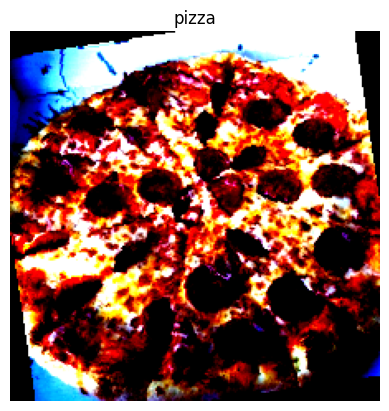

In [7]:
from utils.display import plot_random_images, plot_image

plot_image(image, classes[label])

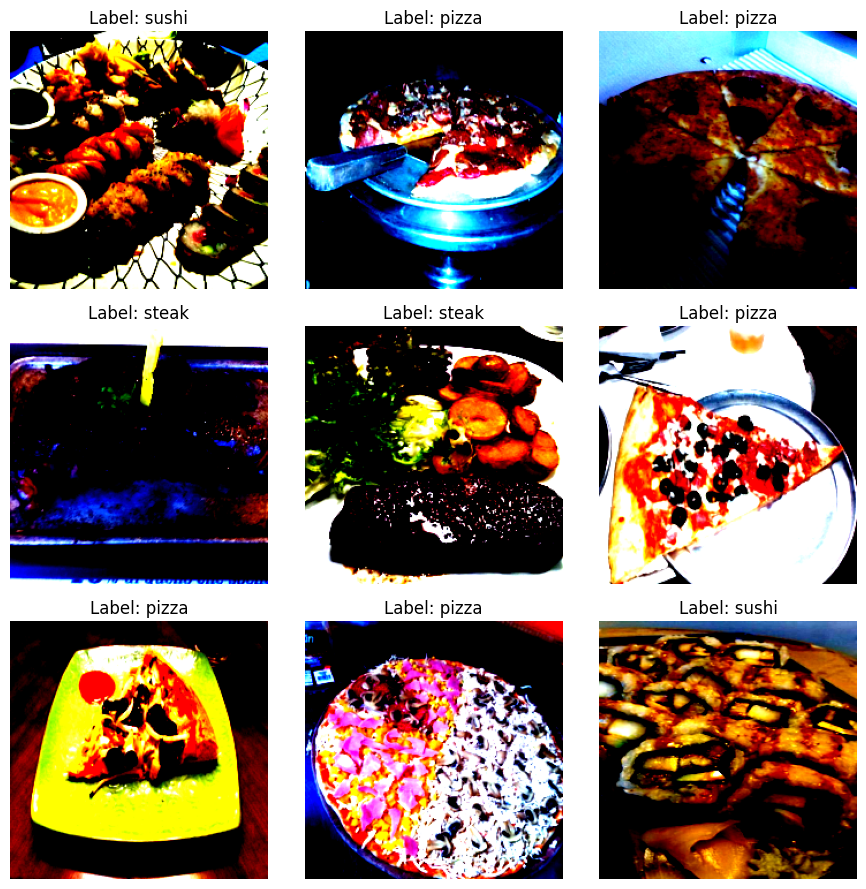

In [8]:
plot_random_images(test_dataset, 9, 42)

## Using the pretrained the resnet model

In [14]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn

# Load pretrained model
model_0 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers except the final FC layer
for name, param in model_0.named_parameters():
    # Only keep FC trainable
    param.requires_grad = ("fc" in name)

# Replace FC for your number of classes
model_0.fc = nn.Linear(model_0.fc.in_features, 3)  # example: 3 classes

model_0 = model_0.to(device)


In [12]:
try:
  from torchinfo import summary
except:
  print("Installing torchinfo")
  !pip install torchinfo
  from torchinfo import summary

summary(model_0, input_size=(32,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]  

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.fc.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=5,
    factor=0.1
)

### Running training and testing

In [17]:
from utils.process import run_train_test

result = run_train_test(
    model = model_0,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    device = torch.device(device),
    epochs = 30,
)

starting....


  0%|          | 0/30 [00:00<?, ?it/s]

[] Allocated: 105.51 MB | Reserved: 400.00 MB
Epoch:0	Train Loss:0.9044	Train Acc:0.5910	Test Loss:0.5723	Test Acc:0.8281
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:1	Train Loss:0.5189	Train Acc:0.8285	Test Loss:0.4114	Test Acc:0.8646
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:2	Train Loss:0.4202	Train Acc:0.8583	Test Loss:0.3655	Test Acc:0.8776
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:3	Train Loss:0.3715	Train Acc:0.8778	Test Loss:0.3484	Test Acc:0.8672
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:4	Train Loss:0.3637	Train Acc:0.8764	Test Loss:0.3345	Test Acc:0.8724
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:5	Train Loss:0.3186	Train Acc:0.8910	Test Loss:0.3121	Test Acc:0.8802
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:6	Train Loss:0.3089	Train Acc:0.8896	Test Loss:0.3003	Test Acc:0.8724
[] Allocated: 105.53 MB | Reserved: 400.00 MB
Epoch:7	Train Loss:0.3105	Train Acc:0.8819	Test Loss:0.2830	Test Acc:0.8932
[] Allocated: 105.53 MB 

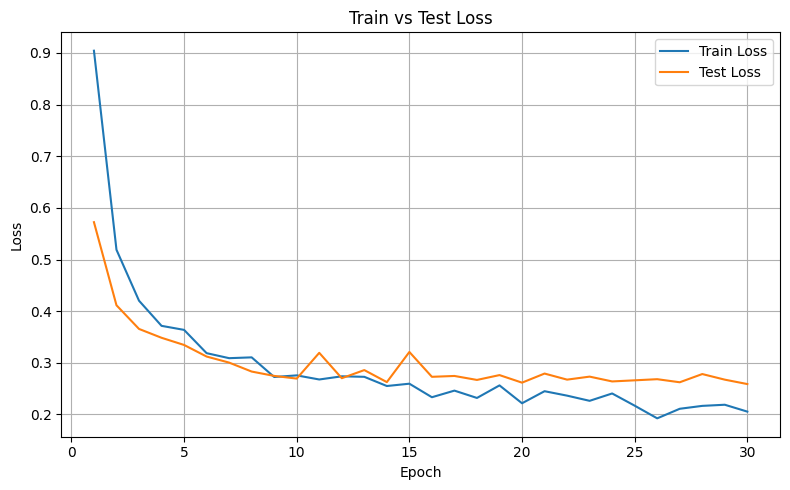

In [18]:
from utils.display import plot_train_vs_test_loss

plot_train_vs_test_loss(result)

In [20]:
from utils.model_utils import analyze_model, get_model_final_result

analyze_model(model_0, train_dataset, test_dataset, classes, device)

total: 1800
correct: 1689
Incorrect: 111
Correct percent:  93.83
average inference time:  3.25


In [22]:
fin_result = get_model_final_result(result)
fin_result

{'train_loss': 0.20539789762761856,
 'train_acc': 0.91875,
 'test_loss': 0.2587773284564416,
 'test_acc': 0.9010416666666666,
 'time': 302.5450451374054}

## Making ResNet from scratch

In [ ]:
from torch import nn

# Convolution block
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super().__init__()
    self.c = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.bn(self.c(x))

#BottleNeck ResudialBlock
class ResudialBlock(nn.Module):
  def __init__(self, in_channels, out_channels, first = False):
    super().__init__()
    res_channels = in_channels // 4
    stride = 1

    self.projection = in_channels != out_channels
    if self.projection:
      self.p = ConvBlock(in_channels, out_channels,1,2,0)
      stride = 2
      res_channels = in_channels // 2

    if first:
      self.p = ConvBlock(in_channels, out_channels, 1, 1, 0)
      stride = 1
      res_channels = in_channels

    self.c1 = ConvBlock(in_channels, res_channels, 1,1,0)
    self.c2 = ConvBlock(res_channels, res_channels, 3,stride,1)
    self.c3 = ConvBlock(res_channels, out_channels, 1,1,0)
    self.relu = nn.ReLU()

  def forward(self, x):
    f = self.relu(self.c1(x))
    f = self.relu(self.c2(f))
    f = self.c3(x)

    if self.projection:
      x = self.p(x)

    h = self.relu(torch.add(f,x))
    return h

class ResNet(nn.Module):
  def __init__(self, no_blocks, in_channels = 3, classes = 3):
    super().__init__

    out_features = [256, 512, 1024, 2048]
    self.blocks = nn.ModuleList([ResudialBlock(64, 256, True)])

    for i in range(len(out_features)):
      if i > 0:
        self.blocks.append(ResudialBlock(out_features[i]))
      for _ in range(no_blocks[i]-1)


### saving the model

In [23]:
!mkdir -p models
dest = Path("./models")
dest.exists()

True

In [24]:
from utils.model_utils import save_model

metadata = {
    "arch": "ResNet16",
    "desc": "Pretrained Deep Resudial Network model in which classifier layer is fine tuned for three classes (pizza, steak, sushi)",
    "train_acc": round(result["train_acc"][-1]*100, 2),
    "training_images": len(train_dataset),
    "parameters":sum(p.numel() for p in model_0.parameters())
}

save_model(
    model = model_0,
    metadata = metadata,
    name = "ResNet16",
    loc = dest,
    device = torch.device(device)
)

model saved at models/ResNet16.pt


## saving
* entire model
* model state dict

In [25]:
torch.save(model_0, dest/"ResNet16_full.pth")
torch.save(model_0.state_dict(), dest/"ResNet6_state_dict_full.pth")